In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from train import create_parser
from network import ToyNet
from diffusion import Follmer
from data import get_target_fn
from misc import dict2obj
from data import get_target_fn, compute_target_mean_and_sd
from misc import append_dims
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
defaults = dict(device=0, seed=42, mode='ode',data_name='m1', nsample=5000, output='logs/m1/ckpt',
                data_dim=1, cond_dim=5, sigma_data=1, M=1,bsz=1000, train_steps=5000, lr=1e-3, 
                dump_freq=1000, print_freq=500,ode_solver='euler', sde_solver='euler-maruyama', 
                eps0=1e-3, eps1=1e-3, num_steps=1000, heun_steps=13, ntest=5000, nMC=200,teacher_path='')

args=dict2obj(defaults)
os.makedirs(args.output, exist_ok=True)
device = torch.device(f"cuda:{args.device}") if torch.cuda.is_available() else torch.device("cpu")
np.random.seed(args.seed)

target_fn = get_target_fn(args.data_name)
cond = np.random.uniform(-3,3,[args.nsample, args.cond_dim])
data = target_fn(cond)
data = torch.from_numpy(data).float()
cond = torch.from_numpy(cond).float()
dataset = TensorDataset(data, cond)
loader = DataLoader(dataset, batch_size=args.bsz, shuffle=True, drop_last=True)
def create_infinite_dataloader(loader):
    while True:
        yield from loader
loader = create_infinite_dataloader(loader)
model = ToyNet(args.data_dim, args.cond_dim, hidden_dims=[32, 16]).to(device)
optim = torch.optim.Adam(model.parameters(), lr=args.lr)
sde = Follmer(args)

for step in range(1, args.train_steps+1):
    batch, cond = next(loader)
    batch  = batch.to(device)
    cond = cond.to(device)
    optim.zero_grad()
    if args.mode=='ode':
        loss = sde.compute_dsm_loss(model, batch, cond)
    elif args.mode=='sde':
        loss = sde.compute_schr_loss(model, batch, cond)
    loss.backward()
    optim.step()
    if step % args.print_freq == 0:
        print(f"Step[{step}/{args.train_steps}], Loss {loss.item():.4f}")
    if step % args.dump_freq == 0 or step == args.train_steps:
        torch.save(dict(model=model.state_dict(), optim=optim.state_dict, step=step), 
                f"{args.output}/{step}.pth")

Step[500/5000], Loss 2.6570
Step[1000/5000], Loss 1.8094
Step[1500/5000], Loss 1.4915
Step[2000/5000], Loss 1.4568
Step[2500/5000], Loss 1.4866
Step[3000/5000], Loss 1.3037
Step[3500/5000], Loss 1.2216
Step[4000/5000], Loss 1.1837
Step[4500/5000], Loss 1.0843
Step[5000/5000], Loss 1.0528


In [2]:
#defaults = dict(device=0, seed=1234, mode='ode',data_name='m1', output='logs/m1',data_dim=1, cond_dim=5, sigma_data=1, M=1,
#                ode_solver='euler', sde_solver='euler-maruyama', nplot=5000, ntest=5000, nMC=200, nrepeat=10,
#                eps0=1e-3, eps1=1e-3, num_steps=1000, ckpt_path='logs/m1/ckpt/5000.pth')
#args=dict2obj(defaults)
#os.makedirs(args.output, exist_ok=True)
#device = torch.device(f"cuda:{args.device}") if torch.cuda.is_available() else torch.device("cpu")
#target_fn = get_target_fn(args.data_name)
#cond = np.random.randn(args.nplot, args.cond_dim)

#model = ToyNet(args.data_dim, args.cond_dim, hidden_dims=[32, 16]).to(device)
#model.load_state_dict(torch.load(args.ckpt_path, map_location=device)['model'])
#sde = Follmer(args)
if args.mode=='ode':
    grid = torch.linspace(1-args.eps1, args.eps0, args.num_steps, device=device)
elif args.mode=='sde':
    grid = torch.linspace(args.eps0, 1-args.eps1, args.num_steps, device=device)
    
#np.random.seed(args.seed)
if args.mode=='ode':
    x1 = sde.sampling_priorc(shape=[args.nMC*args.ntest, args.data_dim], device=device)
elif args.mode=='sde':
    x1 = sde.sampling_prior(shape=torch.Tensor(args.nMC*args.ntest, args.data_dim), device=device)
cond = np.random.randn(args.ntest, args.cond_dim)
cond = np.random.uniform(-3,3,[args.ntest, args.cond_dim])
mean, sd = compute_target_mean_and_sd(args.data_name, cond)
mean_ = np.empty_like(mean)
sd_ = np.empty_like(sd)
cond = np.repeat(cond, args.nMC, axis=0)
cond = torch.from_numpy(cond).float().to(device)
with torch.no_grad():
    if args.mode=='ode':
        x0 = sde.solve_ode(model, x1, grid, args.ode_solver, cond).cpu().numpy()
    elif args.mode=='sde':
        x0 = sde.solve_sde(model, x1, grid, args.sde_solver, cond).cpu().numpy()
pred = x0
for j in range(args.ntest):
    mean_[j] = np.mean(pred[j*args.nMC:(j+1)*args.nMC, :])
    sd_[j] = np.std(pred[j*args.nMC:(j+1)*args.nMC, :])
mse_mean = np.mean(np.square(mean - mean_))
mse_sd = np.mean(np.square(sd - sd_))
print(f'MSE(mean):{mse_mean:.3f}, MSE(SD)={mse_sd.mean():.3f}')

MSE(mean):0.120, MSE(SD)=0.028


0.2765857636406688
6.227005481719971


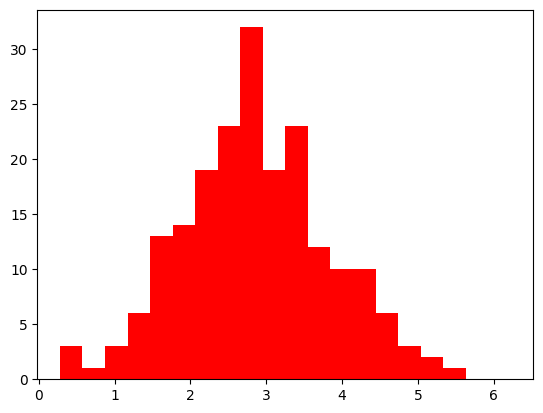

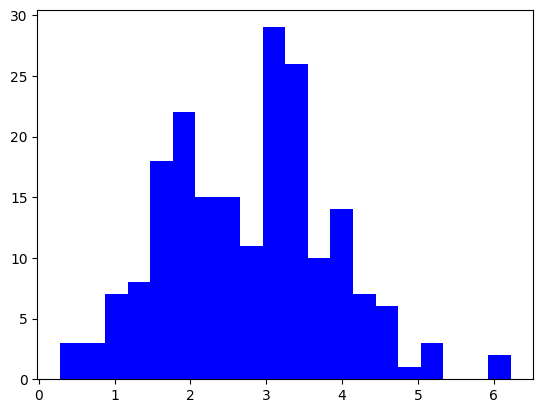

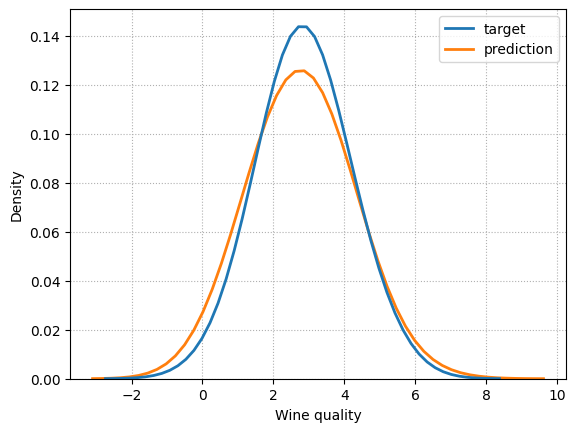

In [3]:
j=3
target_test=mean[j] + sd[j]*torch.randn(torch.tensor(args.nMC), device=device)
cond1=cond[j*args.nMC:(j+1)*args.nMC, :].cpu().numpy()
target_test=target_fn(cond1)
target_test=target_test.flatten()
pred_test=pred[j*args.nMC:(j+1)*args.nMC, :].flatten()
a=np.min([np.min(target_test),np.min(pred_test)])
b=np.max([np.max(target_test),np.max(pred_test)])
print(a)
print(b)
plt.hist(target_test,bins=20,color="r",range=(a,b))
plt.figure()
plt.hist(pred_test,bins=20,color="b",range=(a,b))
plt.figure()
sns.kdeplot({"target": target_test, "prediction": pred_test}, bw_adjust=3, linewidth=2, gridsize=50)
plt.xlabel("Wine quality")
plt.grid(linestyle=':')